<a href="https://colab.research.google.com/github/fAikoH-dot/TCC-v1/blob/main/prophet/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# !pip install prophet

In [21]:
# %pip install python-bcb

In [22]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

In [23]:
df = pd.read_csv('../../data library/Soja_v1.csv', sep=";")
df = df.sort_values(by='Data').reset_index(drop=True)
df.rename(columns={"Data":"ds", "Estadual":"y"}, inplace=True)
df.head()

ds Cultivo        y     País  Id     Último   Abertura     Máxima  \
0  2004-03-01    Soja  45.3777  50.0455   0      1.034      1.000      1.064   
1  2004-04-01    Soja  45.9456  48.7279   0  81400.000      1.036      1.063   
2  2004-05-01    Soja  44.8723  47.4930   0  89300.000  82800.000  94000.000   
3  2004-06-01    Soja  38.5913  40.7781   0  59950.000  89200.000      1.035   
4  2004-07-01    Soja  34.0818  37.5474   0  62725.000  59100.000  71200.000   

    Mínima  
0  92600.0  
1  81200.0  
2      0.0  
3  59900.0  
4  56500.0

In [24]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [25]:
clima = pd.read_csv("../../data library/Clima/MT_dados.csv", sep=';')
clima.rename(columns={"PRECIPITACAO TOTAL":"precipitacao", "TEMPERATURA MEDIA":"temperatura"}, inplace=True)

clima["precipitacao"] = clima.precipitacao.str.replace(',', '.')
clima["temperatura"] = clima.temperatura.str.replace(',', '.')

clima.bfill(inplace=True)
clima.head()

Data Medicao precipitacao temperatura
0   31/03/2004        175.4        24.9
1   30/04/2004        175.4        24.5
2   31/05/2004           23        21.7
3   30/06/2004         18.8        22.1
4   31/07/2004           38        22.2

In [26]:
df["USD"] = df_usd["USD"]
df["Precipitacao"] = clima["precipitacao"].astype(float)
df["Temperatura"] = clima["temperatura"].astype(float)
df['lag_Estadual'] = df['y'].shift(1)
df['lag_Estadual'] = df['lag_Estadual'].bfill()
df.head()

ds Cultivo        y     País  Id     Último   Abertura     Máxima  \
0  2004-03-01    Soja  45.3777  50.0455   0      1.034      1.000      1.064   
1  2004-04-01    Soja  45.9456  48.7279   0  81400.000      1.036      1.063   
2  2004-05-01    Soja  44.8723  47.4930   0  89300.000  82800.000  94000.000   
3  2004-06-01    Soja  38.5913  40.7781   0  59950.000  89200.000      1.035   
4  2004-07-01    Soja  34.0818  37.5474   0  62725.000  59100.000  71200.000   

    Mínima       USD  Precipitacao  Temperatura  lag_Estadual  
0  92600.0  2.905457         175.4         24.9       45.3777  
1  81200.0  2.905985         175.4         24.5       45.3777  
2      0.0  3.100419          23.0         21.7       45.9456  
3  59900.0  3.129148          18.8         22.1       44.8723  
4  56500.0  3.036777          38.0         22.2       38.5913

In [27]:
def plot_predictions(testing_dates, y_test, prediction):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
    _, ax = plt.subplots(figsize=(10, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual")
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
    plt.legend(["Actual", "Prediction"])
    plt.show()

In [28]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

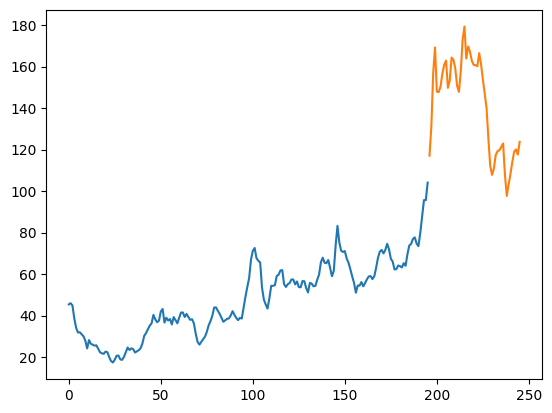

In [29]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.ds

plt.plot(train.y)
plt.plot(test.y)

# Univariado

In [30]:
m = Prophet()
m.fit(train)

# m.params

23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:17 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
forecast = m.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2020-08-01  76.955598   66.352678   86.986446
1 2020-09-01  78.499337   68.254871   89.034810
2 2020-10-01  78.571636   68.677612   88.205359
3 2020-11-01  78.858561   68.114063   88.497947
4 2020-12-01  78.266230   67.687820   88.677577

In [32]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

ds         y       yhat
0  2020-08-01  117.0222  76.955598
1  2020-09-01  130.8449  78.499337
2  2020-10-01  156.7972  78.571636
3  2020-11-01  169.1946  78.858561
4  2020-12-01  147.9145  78.266230

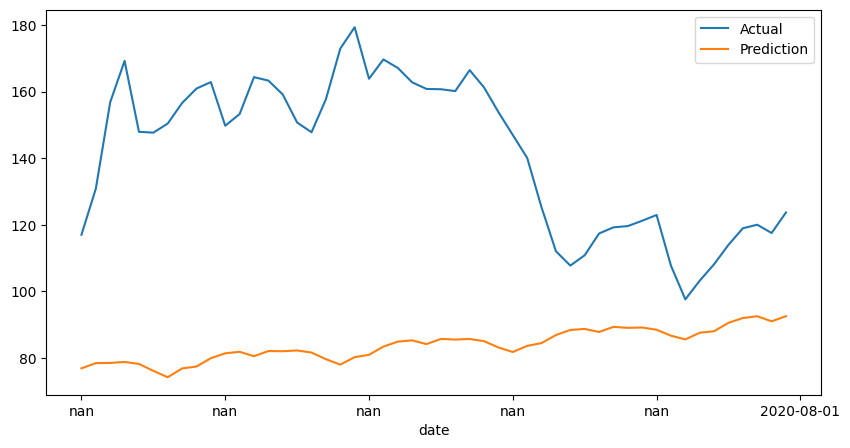

MAE: 57.664301804718534
RMSE: 63.16513800221519
MAPE: 0.38705825933962656
R-Squared: -6.768006728293025


In [33]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

# Multivariado

In [34]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

# m.params

23:37:18 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
test_1 = test[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']]
test_1.head()

ds       USD      País       Último       Máxima  lag_Estadual
0  2020-08-01  5.280191  113.3375  95250.00000  96688.00000      104.0607
1  2020-09-01  5.461233  128.3004      1.02175      1.04650      117.0222
2  2020-10-01  5.399486  147.4121      1.05688      1.09388      130.8449
3  2020-11-01  5.625790  157.3982      1.16875      1.19962      156.7972
4  2020-12-01  5.417835  140.9301      1.31025      1.32060      169.1946

In [36]:
# future = m.make_future_dataframe(periods=len(test_1), freq='MS')
# future.head()

In [37]:
forecast = m.predict(test_1)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        yhat  yhat_lower  yhat_upper
0 2020-08-01  111.139290  109.243474  113.151204
1 2020-09-01  128.175342  126.231634  130.312585
2 2020-10-01  147.863654  145.880548  149.732979
3 2020-11-01  160.387330  158.492697  162.282123
4 2020-12-01  145.899544  144.004150  147.877775

In [38]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

ds         y      País       USD        yhat
0  2020-08-01  117.0222  113.3375  5.280191  111.139290
1  2020-09-01  130.8449  128.3004  5.461233  128.175342
2  2020-10-01  156.7972  147.4121  5.399486  147.863654
3  2020-11-01  169.1946  157.3982  5.625790  160.387330
4  2020-12-01  147.9145  140.9301  5.417835  145.899544

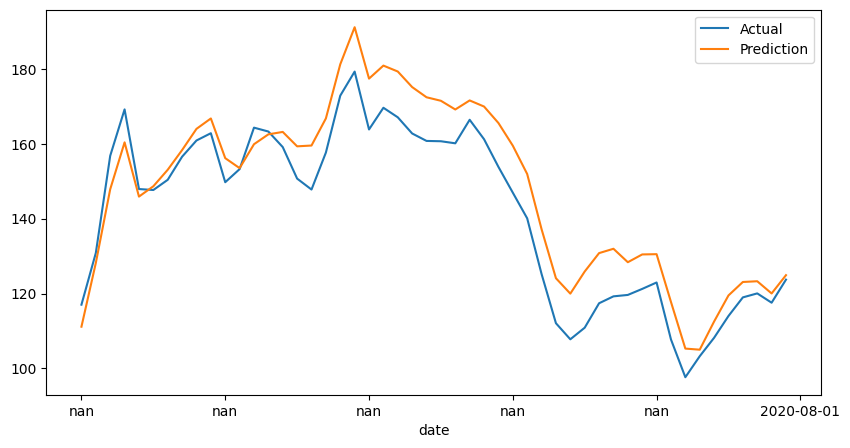

MAE: 7.611000337913269
RMSE: 8.693223839572813
MAPE: 0.0552276519622423
R-Squared: 0.8528648558600913


In [39]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

In [40]:
aux_var = ['USD', 'País', 'Último', 'Máxima', 'lag_Estadual']
future_dates = m.make_future_dataframe(periods=((len(test_1))+24), freq="MS")

In [41]:
extended_df = future_dates.copy()

for i in aux_var:
    train_aux = train[['ds', i]].copy()
    train_aux.rename(columns={i:"y"}, inplace=True)

    m = Prophet()
    m.fit(train_aux)
    forecast = m.predict(future_dates)
    
    extended_df[i] = forecast["yhat"]

extended_df

23:37:18 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing
23:37:18 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:20 - cmdstanpy - INFO - Chain [1] done processing


ds       USD        País        Último        Máxima  lag_Estadual
0   2004-03-01  2.814078   25.581313  35949.356883  29380.735440     20.796011
1   2004-04-01  2.785586   25.091087  29875.044112  23145.454852     20.960161
2   2004-05-01  2.809846   26.178504  30261.996334  35065.663843     21.544774
3   2004-06-01  2.843009   27.206649  28756.628044  24576.524429     24.020413
4   2004-07-01  2.775656   28.134790  29149.423810  23019.412387     25.589320
..         ...       ...         ...           ...           ...           ...
265 2026-05-01  6.227675  100.375367  68582.216507  64435.949794     94.260163
266 2026-06-01  6.277252  101.594884  66885.153717  53768.473832     96.709218
267 2026-07-01  6.269313  102.278598  67812.561329  52355.724084     98.135074
268 2026-08-01  6.228821  101.261075  69331.860623  54414.332975     96.943966
269 2026-09-01  6.290234  102.697078  82066.815386  58887.490802     97.373442

[270 rows x 6 columns]

In [42]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

23:37:20 - cmdstanpy - INFO - Chain [1] start processing
23:37:20 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
real_data = df[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']].copy()
final_date = df["ds"][-1:]
predicted_data = extended_df[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']][len(train)+len(test):]

real_data_2 = pd.concat([real_data, predicted_data], ignore_index=True)

In [44]:
test_2 = real_data_2[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']][train_size:].reset_index(drop=True)
test_2.head()

ds       USD      País       Último       Máxima  lag_Estadual
0  2020-08-01  5.280191  113.3375  95250.00000  96688.00000      104.0607
1  2020-09-01  5.461233  128.3004      1.02175      1.04650      117.0222
2  2020-10-01  5.399486  147.4121      1.05688      1.09388      130.8449
3  2020-11-01  5.625790  157.3982      1.16875      1.19962      156.7972
4  2020-12-01  5.417835  140.9301      1.31025      1.32060      169.1946

In [45]:
final_forecast = m.predict(test_2)
final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        yhat  yhat_lower  yhat_upper
0 2020-08-01  111.139290  109.219409  112.979263
1 2020-09-01  128.175342  126.198898  129.868555
2 2020-10-01  147.863654  145.961115  149.776830
3 2020-11-01  160.387330  158.483334  162.308506
4 2020-12-01  145.899544  144.122765  147.817157

In [46]:
test_2.reset_index(inplace=True, drop=True)
test_2['y'] = test['y']
test_2.fillna(0, inplace=True)
final_df = test_2[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = final_forecast['yhat']
final_df.head()

ds         y      País       USD        yhat
0  2020-08-01  117.0222  113.3375  5.280191  111.139290
1  2020-09-01  130.8449  128.3004  5.461233  128.175342
2  2020-10-01  156.7972  147.4121  5.399486  147.863654
3  2020-11-01  169.1946  157.3982  5.625790  160.387330
4  2020-12-01  147.9145  140.9301  5.417835  145.899544

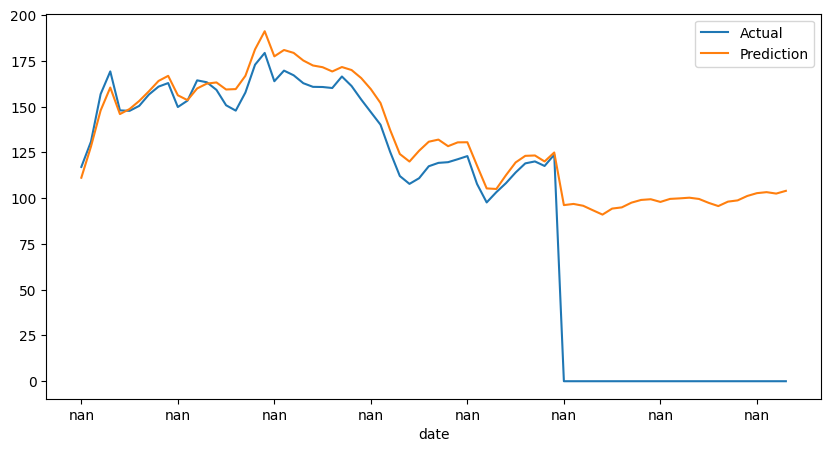

MAE: 37.020466532178055
RMSE: 56.45868997547407
MAPE: 1.4356529287011328e+17
R-Squared: 0.3274720408896755


In [47]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

In [48]:
final_df.to_csv('../../Soja/Soja_Resultados.csv', sep=',', index=False)